In [1]:
import numpy as np
import h5py
import os
from tqdm.notebook import tqdm
import copy
import matplotlib.pyplot as plt
from pde import MemoryStorage
# import tracemalloc

from methods.base import BaseConfig
from methods.io_things import add_data_to_h5dataset, split_hdf5_random 
from methods.plotting import plot_perm, plot_press, plot_event_list, plot_events_projection
from methods.pore_press_calc_functions import Diffusion_with_Source_and_Gravity, Non_Uniform_Diffusion_with_Source_and_Gravity, test_wells, get_q_factors
from methods.seism_calc_functions import Micro_Seismic_Seeds, get_litostat_pressure, get_stress, \
    get_norm_and_shear_stress_on_seeds, check_colomb_criteria, get_raw_events, resample_raw_events, get_events, get_events_list, pad_events, get_events_vs_time

In [2]:
# setup base params and eq
params = BaseConfig(
            sources = [{'loc':(2000, 2000, 1500), 'Q':[1, 1], 'P': 0.2}, # P - target overpressue relative to max pressure in sources (if p0=0.1 MPa, P=-0.05 => abs pressure = 0.1 - 0.05 = 0.05 MPa)
                       {'loc':(500, 500, 1500), 'Q':[-0.25, -0.25], 'P': -0.05},
                       {'loc':(3500, 500, 1500), 'Q':[-0.25, -0.25], 'P': -0.05},
                       {'loc':(3500, 3500, 1500), 'Q':[-0.25, -0.25], 'P': -0.05},
                       {'loc':(500, 3500, 1500), 'Q':[-0.25, -0.25], 'P': -0.05},],
            time_scale = 3600, 
            t_range = 120,
            NSAMPL = 200,
            )

params.dump()

# params = BaseConfig()
# params.load() # loading from existing params.yaml file. To dump some BaseConfig oject use its .dump(filename) mehod

# eq initial setup
eq = Diffusion_with_Source_and_Gravity(np.ones(params.shape), params)
storage = MemoryStorage(write_mode='truncate')

In [41]:
# wells testing if needed (it takes about 6 min)
press_in_locs, interpolators = test_wells(eq, params, k_list=10**np.linspace(-1, 5, 30))

  0%|          | 0/30 [00:00<?, ?it/s]

In [3]:
filename = 'downscaled_models_04_16_2024__17_47_01.h5'

with h5py.File(filename, 'r') as f:
    mshape = f['perm'].shape
    nmodels = mshape[0]

idx_list = range(8959, nmodels)
# idx_list = [8949,8959]

pbar = tqdm(idx_list)

# tracemalloc.start()

for ii in pbar:
    
    '''reading data'''
    pbar.set_postfix({'reading data: ': ii})

    with h5py.File(filename, 'r') as f:
        perm = f['perm'][ii]
        dens = f['dens'][ii]

    '''fluid dyn modeling'''
    pbar.set_postfix({'fluid dyn modeling': ii})

    eq.xi_field = eq.update_xi_field(perm) # updating permeability field

    p0 = eq.pore_ini_field
    q_factors = get_q_factors(perm, p0, params)
    eq.source_field = eq.update_source_field(0, q_factors) # updating source fields q_new = q * factor

    res = eq.solve(p0, t_range=params.t_range, adaptive=True, tracker=[storage.tracker(1)])
    # res = eq.solve(p0, t_range=params.t_range, adaptive=True, tracker=['progress', 'plot', storage.tracker(1)]) # use it for testing
    pore_press = np.stack(storage.data, axis=0) # 4d np array

    '''seismic modeling'''
    pbar.set_postfix({'seismic modeling': ii})
    seeds = Micro_Seismic_Seeds(params) # creating microseismic seeds obj
    tan_phi, C, norms = seeds.tan_phi_rvs, seeds.C_rvs, seeds.norms_rvs

    lithostat_pressure = get_litostat_pressure(params, dens)
  
    stress = get_stress(params, lithostat_pressure) # litostatic stress tensor based on density model
    sigma_n, tau = get_norm_and_shear_stress_on_seeds(stress, norms) # stresses without pore pressure

    colomb_pass = check_colomb_criteria(params, pore_press, tan_phi, C, sigma_n, tau) # (dim broadcasting) 

    raw_events = get_raw_events(params, colomb_pass) # num of seeds passed in every cell
    events_dens = resample_raw_events(params, raw_events) # event probability (raw_events normalized to target num)
    events = get_events(params, events_dens) # events

    events_list = get_events_list(events) # list of events (time, x, y, d, Mag)

    events_by_time = np.sum(events, axis=(1,2,3)) # events number at every step
    tot_events = np.sum(events)

    seeds = None # try to avoid memory leak

    '''saving'''
    pbar.set_postfix({'saving data': ii})
    ev_len_with_pad = params.target_events_num + params.events_list_pad # 10% padding for data shape consistency
    padded_events = pad_events(events_list, ev_len_with_pad) # fills extra lines with -1

    add_data_to_h5dataset(filename, ii, padded_events, 'events')
    add_data_to_h5dataset(filename, ii, pore_press[-1], 'pore')
    add_data_to_h5dataset(filename, ii, np.cumsum(events_dens, axis=0)[-1], 'ev_dens') # cumulative seismic density al the last step  

    # print(tracemalloc.get_traced_memory())

# tracemalloc.stop()

# at last writing params to file just for the case
fname_for_params = f'params_{filename.split('.')[0]}.yaml'
params.dump(fname_for_params)



  0%|          | 0/941 [00:00<?, ?it/s]

Permeability map


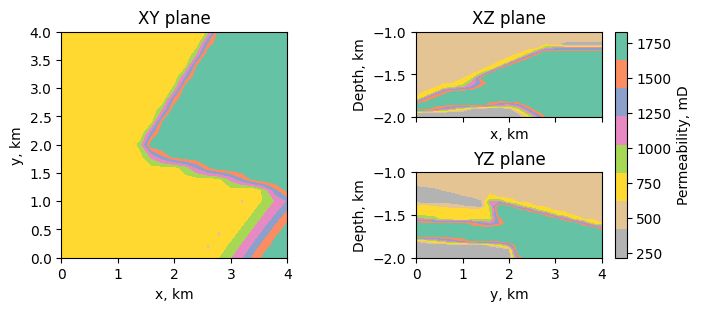

Pore pressure at the fimal step


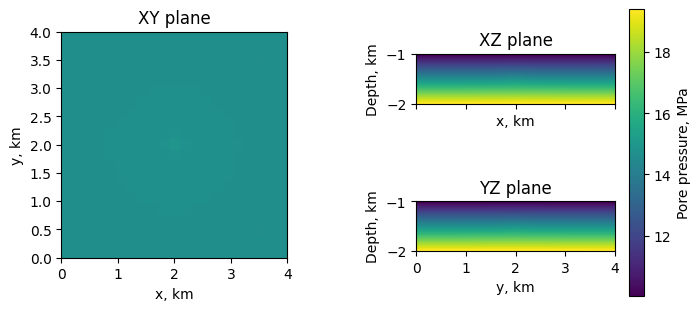

Events
Seismic density at the fimal step


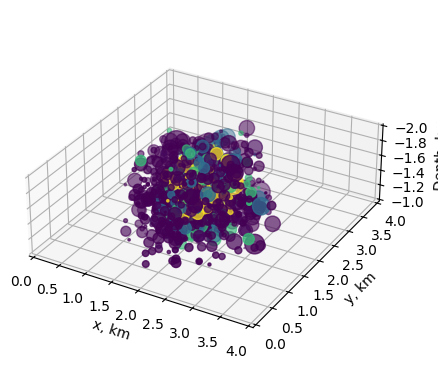

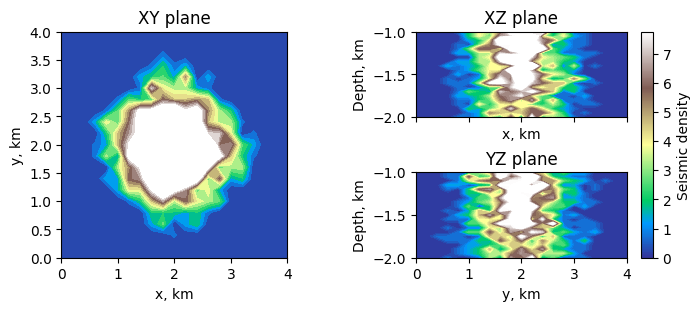

Pore pressure at the fimal step at source location slice


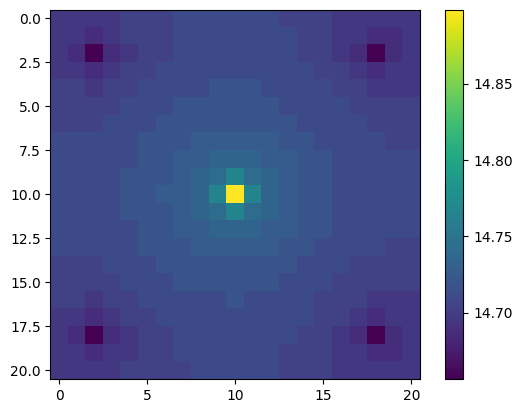

In [5]:
filename = 'downscaled_models_04_16_2024__17_47_01.h5'
# filename = 'test.h5'
jj = 9899 # last = 8959

with h5py.File(filename, 'a') as f:
    ev = f['events'][jj]
    pp = f['perm'][jj]
    pore = f['pore'][jj]
    ev_d = f['ev_dens'][jj]

spec_params = BaseConfig()
spec_params.load() # loading params

print('Permeability map')
plot_perm(pp, loc=(10, 10, 10), params=spec_params)

print('Pore pressure at the fimal step')
plot_press(pore, loc=(10, 10, 10), params=spec_params)

print('Events')
plot_event_list(ev[0:900], params=spec_params)

print('Seismic density at the fimal step')
plot_events_projection(ev_d, params=spec_params)

print('Pore pressure at the fimal step at source location slice')
fig, ax = plt.subplots()
ims = ax.imshow(pore[:,:,10]) # pore press at source location slice
plt.colorbar(ims, ax=ax)

In [ ]:
# checking results 
filename = 'downscaled_models_04_16_2024__17_47_01.h5'

rr = range(0,9900)

pore_min_max = np.zeros((len(rr),2))
ev_d_max = np.zeros((len(rr)))
pbar = tqdm(rr)
for jj in pbar:
    with h5py.File(filename, 'a') as f:
        pbar.set_description(f"Checking data: jj={jj}")
        ev = f['events'][jj]
        pp = f['perm'][jj]
        pore = f['pore'][jj]
        ev_d = f['ev_dens'][jj]

        pore_min_max[jj] = np.min(pore), np.max(pore)
        ev_d_max[jj] = np.max(pore)


In [6]:
print(np.min(pore_min_max))
print(np.max(pore_min_max))
np.where(pore_min_max[:,0]<9.8)

8.359375
19.75


(array([4847, 5679, 7008, 7852, 8640], dtype=int64),)

In [10]:
# splittin h5 into train and test subsets
filename = 'downscaled_models_04_16_2024__17_47_01.h5'
train_name = "train.h5"
test_name = "test.h5"
split_percent = 0.8

split_hdf5_random(filename, train_name, test_name, split_percent)
print('ok')

ok


In [ ]:
def get_events_vs_time(events):
    '''returns event count vs time'''
    times, counts = np.unique(events[:,0], return_counts=True)
    events_vs_time = np.stack((times[times>=0], counts[times>=0]))
    return events_vs_time


  0%|          | 0/100 [00:00<?, ?it/s]

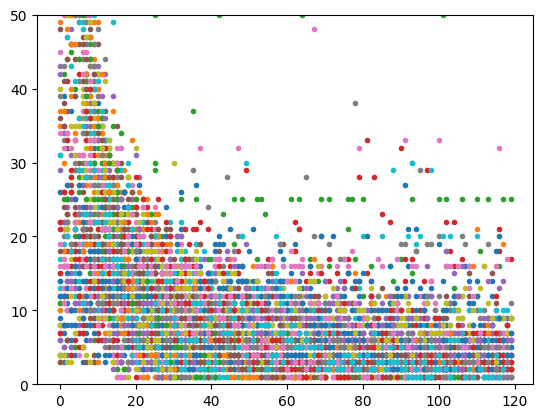

In [9]:
# average events vs time
filename = 'downscaled_models_04_16_2024__17_47_01.h5'

float_list = 9900 * np.random.rand(100)
fig, ax = plt.subplots()

all_events_vs_time = []
pbar = tqdm(float_list)
for jj in pbar:
    with h5py.File(filename, 'a') as f:
        events = f['events'][int(jj)]
        events_vs_time = get_events_vs_time(events)
        ax.plot(events_vs_time[0], events_vs_time[1], linestyle='', marker='.')
        ax.set_ylim([0,50])


